In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [2]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann

In [3]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [29]:
def matrice_raideur_elem(indice,elements3, coordinates, f):

    # Récupération du triangle
    triangle = elements3[indice]

    # Récupération des coordonnées des sommets du triangle
    x1 = coordinates[triangle[0]][0]
    y1 = coordinates[triangle[0]][1]
    x2 = coordinates[triangle[1]][0]
    y2 = coordinates[triangle[1]][1]
    x3 = coordinates[triangle[2]][0]
    y3 = coordinates[triangle[2]][1]

    # Calcul de alpha et T
    alpha = abs((x2-x1)*(y3-y1)-(y2-y1)*(x3-x1))
    T=(1/2)*alpha
    
    # Barycentre 
    xg = (x1+x2+x3)/3
    yg = (y1+y2+y3)/3
    z = (alpha/6)*f(xg,yg)



    grad_etha_i=np.zeros((2,1))
    grad_etha_j=np.zeros((2,1))
    M = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            grad_etha_i[0] = (1/alpha)*(coordinates[triangle[(i+1)%3]][1] - coordinates[triangle[(i+2)%3]][1])
            grad_etha_i[1] = (1/alpha)*(coordinates[triangle[(i+2)%3]][0] - coordinates[triangle[(i+1)%3]][0])
            grad_etha_j[0] = (1/alpha)*(coordinates[triangle[(j+1)%3]][1] - coordinates[triangle[(j+2)%3]][1])
            grad_etha_j[1] = (1/alpha)*(coordinates[triangle[(j+2)%3]][0] - coordinates[triangle[(j+1)%3]][0])
            M[i,j]=abs(T)*np.dot(np.transpose(grad_etha_i),grad_etha_j)
            
    return M,z


In [30]:
def assemblage (elements3, coordinates,dirichlet, f, ud):
  l = len(coordinates)
  A = np.zeros((l,l))
  B = np.zeros((l,1))
  u = np.zeros((l,1))

  #Condition aux limites
  for h in range(len(dirichlet)):
    u[dirichlet[h]] = ud(coordinates[dirichlet[h][0]][0],coordinates[dirichlet[h][0]][1])

  # Assemblage de la matrice A et le vecteur B
  for i in range(len(elements3)):
    M,z = matrice_raideur_elem(i,elements3, coordinates, f)
    triangle = elements3[i]
    for j in range (3):
      for k in range (3):
        A[triangle[j],triangle[k]] += M[j][k]
      B[triangle[j]] += z

  B -= np.dot(A,u)
  
  return A,B,u


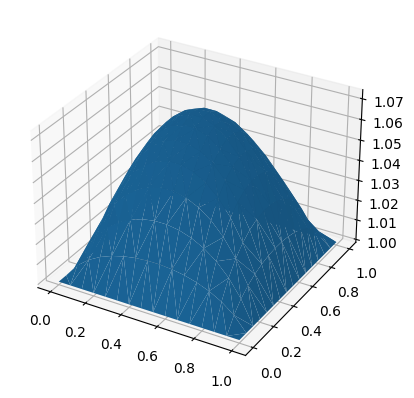

In [43]:
# Définition de la fonction
def f(x,y):
    return 1

def ud(x,y):
    return 1

coordinates, elements3, dirichlet, neumann = maillage(16)
A,B,u = assemblage(elements3, coordinates,dirichlet, f, ud)

# Non prise en compte de la frontière de Dirichlet
sommets = [i for i in range(len(coordinates))]
sommets_sans_dirichlet= np.setdiff1d(sommets, dirichlet)
A_bis = A[sommets_sans_dirichlet]
A_sans_dirichlet = A_bis[:,sommets_sans_dirichlet]
B_sans_dirichlet = B[sommets_sans_dirichlet]

# Résolution du problème
u[sommets_sans_dirichlet] = np.linalg.solve(A_sans_dirichlet,B_sans_dirichlet)

# Affichage de la solution
show(coordinates, (u[:,0]))

**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [ ]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

**Compléments  :  un nouveau terme dans l'EDP**